In [9]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from random import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline 

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Training and testing folder
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
IMG_SIZE = 96

# Remove [:1000] to use all images in train folder
X_train = os.listdir(TRAIN_DIR)[:1000]

In [3]:
def label_img(img):
    '''
    Read image path and parses out 'cat' and 'dog'; Returns 1 if cat, 0 if pupper doggo
    '''
    
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [4]:
def create_train_data():
    '''
    Creates the dataset for training in the required format
    
    Outputs a list of images
    '''
    training_data = []
    for img in tqdm(X_train):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    # shuffle all images to avoid biasness toward a particular class
    shuffle(training_data)
    
    return training_data

In [5]:
# Generate labels for the data

labels = []
for i in X_train:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

Text(0.5, 1.0, 'Cats and Dogs')

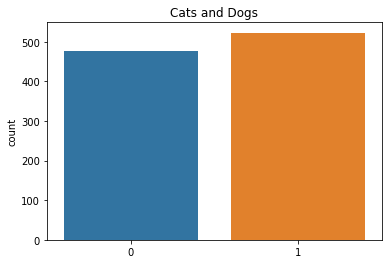

In [6]:
sns.countplot(labels)
plt.title('Cats and Dogs')

In [7]:
train = create_train_data()
print("Done!")

100%|██████████| 1000/1000 [00:12<00:00, 82.79it/s]

Done!


In [10]:
# Convert training data to numpy array
training_images = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)

# Convert training labels to numpy array
training_labels= np.array([i[1] for i in train])

x_train.shape, y_train.shape

((1000, 96, 96, 3), (1000, 2))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(training_images, training_labels, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(900, 96, 96, 3) (900, 2) (100, 96, 96, 3) (100, 2)


Such a good boi!


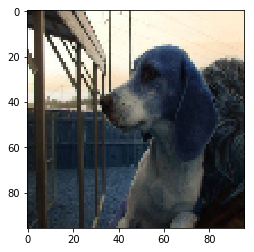

In [14]:
plt.imshow(x_train[500])
print("Such a good boi!")